**Uber Pickups in New York City**  
The project focuses on the analysis of Uber pickup data in New York City (dataset available on [Kaggle](https://www.kaggle.com/datasets/fivethirtyeight/uber-pickups-in-new-york-city)) with the goal of identifying traffic hotspots, hourly trends, and the most relevant areas of the city.  

**Project Objective:**  
To analyze data from multiple months (May–September 2014) in order to obtain meaningful and generalizable results.  
The main goal is to identify the most active zones and the mobility patterns of Uber pickups across NYC.  

**Dataset Format:**  
Each month is stored in a separate CSV file with the following columns:  
- `Date/Time` → pickup timestamp (e.g., `6/1/2014 0:00:00`)  
- `Lat` → latitude of the pickup (e.g., `40.7293`)  
- `Lon` → longitude of the pickup (e.g., `-73.992`)  
- `Base` → identifier of the operating base (e.g., `B02512`)  

Example of a record:  
`6/1/2014 0:00:00, 40.7293, -73.992, B02512`

The original Kaggle dataset contains several monthly files, but this analysis specifically focuses on:  
`uber-raw-data-may14.csv`, `uber-raw-data-jun14.csv`, `uber-raw-data-jul14.csv`, `uber-raw-data-aug14.csv`, and `uber-raw-data-sep14.csv`.


**1. Creation of spatial pickup clusters and centroid-based zone visualization**  
This task aims to visualize and analyze the spatial distribution of Uber pickups across New York City and to identify the main movement flows between areas.  

- Application of **K-Means clustering** on the `Lat` and `Lon` coordinates to define spatial clusters or zones of activity.  
- The resulting clusters implicitly highlight high-density areas (hotspots) based on the concentration of pickup locations.   
- Analysis of inter-cluster transitions over time to identify dominant spatial interaction patterns, visualized using graph networks where nodes represent clusters and edges indicate transitions between zones.


Mounted at /content/drive
✅ Combined dataset shape: (3969811, 4)
            Date/Time      Lat      Lon    Base
0 2014-05-01 00:02:00  40.7521 -73.9914  B02512
1 2014-05-01 00:06:00  40.6965 -73.9715  B02512
2 2014-05-01 00:15:00  40.7464 -73.9838  B02512
3 2014-05-01 00:17:00  40.7463 -74.0011  B02512
4 2014-05-01 00:17:00  40.7594 -73.9734  B02512

📍 Cluster centroids (1–10):
          Lat        Lon
1   40.766454 -73.972750
2   40.777125 -73.638866
3   40.731072 -73.997992
4   40.698447 -74.203151
5   40.709050 -73.946262
6   40.881284 -73.898628
7   40.763493 -73.871519
8   40.802341 -73.313460
9   40.668482 -73.980684
10  40.651797 -73.784272

🔁 Top inter-cluster flows (first rows):
   cluster  next_cluster   count
1        1             2    4306
2        1             3  578594
3        1             4   13799
4        1             5   88250
5        1             6   18932


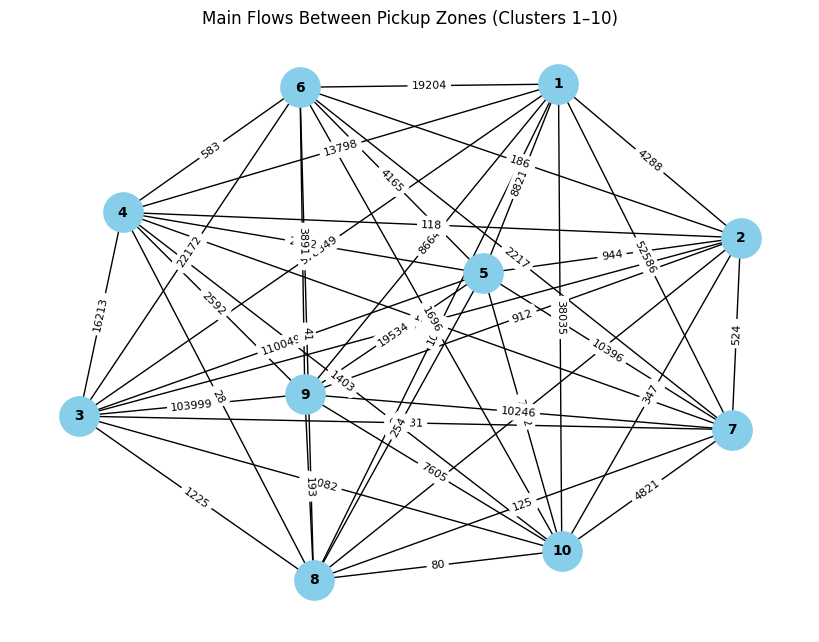


✅ Map with numbered cluster centroids generated:


In [ ]:
# ==========================================
# 🚖 Uber NYC Pickup Analysis (May–September 2014)
# ==========================================

# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
import networkx as nx

# ==========================================
# 📂 Load datasets from Google Drive
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

# 🔸 Modify the paths according to your Drive structure
may = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-may14.csv")
jun = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jun14.csv")
jul = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jul14.csv")
aug = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-aug14.csv")
sep = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-sep14.csv")

# 🔹 Merge all datasets into a single DataFrame
df = pd.concat([may, jun, jul, aug, sep])
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
print("✅ Combined dataset shape:", df.shape)
print(df.head())

# ==========================================
# 📊 K-Means Clustering on Pickup Coordinates
# ==========================================
# Define 10 clusters (zones) based on latitude and longitude
coords = df[['Lat', 'Lon']]
kmeans = KMeans(n_clusters=10, random_state=0)
df['cluster'] = kmeans.fit_predict(coords)

# ✅ Shift cluster numbering from 0–9 → 1–10 (interi)
df['cluster'] = df['cluster'] + 1

# Retrieve cluster centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['Lat', 'Lon'])
centroids_df.index = np.arange(1, len(centroids_df) + 1)

print("\n📍 Cluster centroids (1–10):")
print(centroids_df)

# ==========================================
# 🔁 Flow Analysis Between Clusters
# ==========================================
df = df.sort_values('Date/Time')

# Shift clusters correctly: int without float
df['next_cluster'] = df['cluster'].shift(1)
df['next_cluster'] = df['next_cluster'].fillna(df['cluster']).astype(int)

flows = df.groupby(['cluster', 'next_cluster']).size().reset_index(name='count')
flows = flows[flows['cluster'] != flows['next_cluster']]

print("\n🔁 Top inter-cluster flows (first rows):")
print(flows.head())

# ==========================================
# 🔗 Visualizing Flows as a Graph
# ==========================================
G = nx.from_pandas_edgelist(flows, 'cluster', 'next_cluster', 'count')

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color='skyblue',
    font_weight='bold',
    font_size=10
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u,v):int(d['count']) for u,v,d in G.edges(data=True)},
    font_size=8
)
plt.title("Main Flows Between Pickup Zones (Clusters 1–10)")
plt.show()

# ==========================================
# 🗺️ Visualizing Cluster Centroids on a Map (with numeric labels)
# ==========================================
m_clusters = folium.Map(location=[40.75, -73.97], zoom_start=11)

for i, row in centroids_df.iterrows():
    # Draw red circle marker for the centroid
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=6,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"Cluster {i}",
        tooltip=f"Cluster {i}"
    ).add_to(m_clusters)

    # Add visible numeric label for each cluster
    folium.map.Marker(
        [row['Lat'], row['Lon']],
        icon=folium.DivIcon(
            html=f"""
            <div style="font-size: 12pt; color: black; font-weight: bold;">
                {i}
            </div>
            """
        )
    ).add_to(m_clusters)

print("\n✅ Map with numbered cluster centroids generated:")
m_clusters


**2. Creation of Hourly, Weekly, and Monthly Trend Charts**  
This task aims to identify temporal patterns in Uber pickup activity throughout the day, week, and month.  

- Aggregate pickup counts by **hour of the day**, **day of the week**, and **month**.  
- Create **bar or line charts** to highlight **peak hours** and **weekly trends**, providing insight into passenger demand dynamics.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined dataset shape: (3969811, 4)
            Date/Time      Lat      Lon    Base
0 2014-05-01 00:02:00  40.7521 -73.9914  B02512
1 2014-05-01 00:06:00  40.6965 -73.9715  B02512
2 2014-05-01 00:15:00  40.7464 -73.9838  B02512
3 2014-05-01 00:17:00  40.7463 -74.0011  B02512
4 2014-05-01 00:17:00  40.7594 -73.9734  B02512


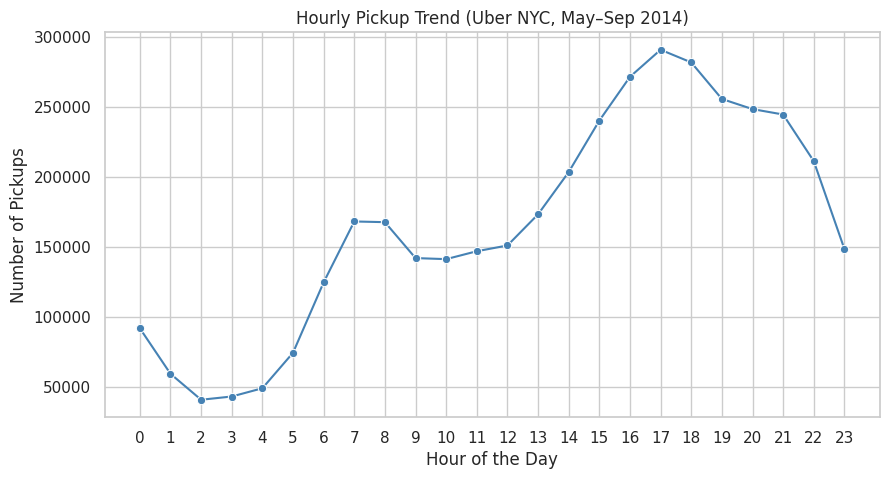

/tmp/ipython-input-2221414965.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pickup_by_weekday.index, y=pickup_by_weekday.values, palette="Blues_d")


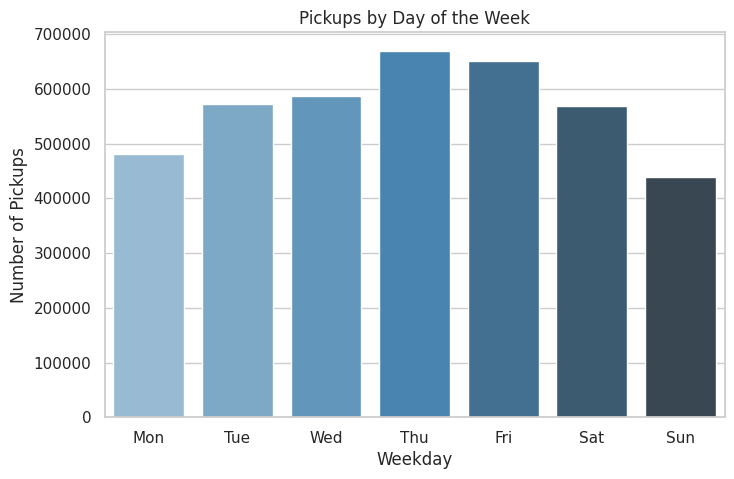

/tmp/ipython-input-2221414965.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pickup_by_month.index, y=pickup_by_month.values, palette="crest")


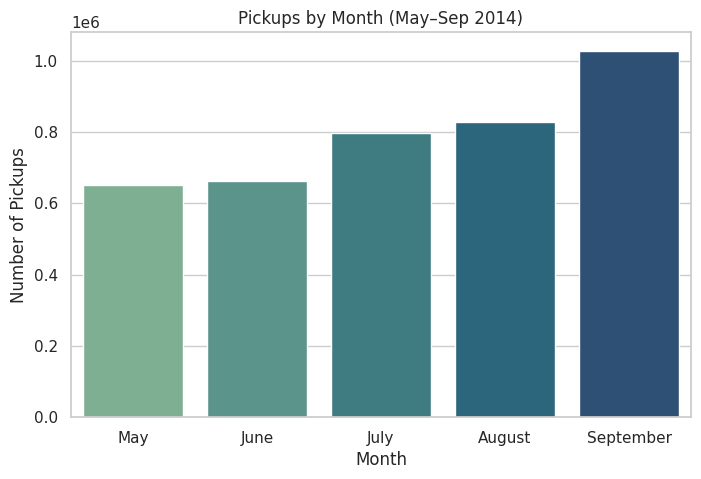

In [ ]:
# ==========================================
# 🚖 Temporal Trend Analysis of Uber Pickups (NYC, May–September 2014)
# ==========================================

# 📦 Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 📂 Load datasets from Google Drive
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

# 🔸 Modify the paths according to your file structure
may = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-may14.csv")
jun = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jun14.csv")
jul = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jul14.csv")
aug = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-aug14.csv")
sep = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-sep14.csv")

# 🔹 Merge all datasets into one
df = pd.concat([may, jun, jul, aug, sep])
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
print("✅ Combined dataset shape:", df.shape)
print(df.head())

# ==========================================
# 🕒 Extract temporal components
# ==========================================
# Extract hour, weekday, and month for trend analysis
df['hour'] = df['Date/Time'].dt.hour
df['weekday'] = df['Date/Time'].dt.dayofweek + 1   # 1 = Monday, 7 = Sunday
df['month'] = df['Date/Time'].dt.month

# Human-readable labels for visualization
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_labels = ['May', 'June', 'July', 'August', 'September']

# ==========================================
# 📊 Temporal trend analysis
# ==========================================

# 🚗 Number of pickups by hour
pickup_by_hour = df.groupby('hour').size()

# 🚕 Number of pickups by weekday
pickup_by_weekday = df.groupby('weekday').size()

# 🚙 Number of pickups by month
pickup_by_month = df.groupby('month').size()

# ==========================================
# 📈 Visualizations
# ==========================================
sns.set(style="whitegrid")

# 1. Hourly trend
plt.figure(figsize=(10,5))
sns.lineplot(x=pickup_by_hour.index, y=pickup_by_hour.values, marker='o', color='steelblue')
plt.title("Hourly Pickup Trend (Uber NYC, May–Sep 2014)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(0, 24))
plt.show()

# 2. Weekly trend
plt.figure(figsize=(8,5))
sns.barplot(x=pickup_by_weekday.index, y=pickup_by_weekday.values, palette="Blues_d")
plt.title("Pickups by Day of the Week")
plt.xlabel("Weekday")
plt.ylabel("Number of Pickups")
plt.xticks(ticks=range(7), labels=weekday_labels)  # tick da 0 a 6
plt.show()

# 3. Monthly trend
plt.figure(figsize=(8,5))
sns.barplot(x=pickup_by_month.index, y=pickup_by_month.values, palette="crest")
plt.title("Pickups by Month (May–Sep 2014)")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.xticks(range(5), month_labels)
plt.show()


**3. Predictive Model for Hourly Uber Pickup Demand**  
This task focuses on developing a predictive model to estimate hourly Uber pickup demand in New York City based on temporal patterns.  

- Aggregate the dataset by **hour** (`Date/Time → count of pickups`) to capture temporal pickup patterns.  
- Create **temporal features** such as `hour`, `weekday`, and `month` to represent time-based behavior.  
- Train a **Random Forest Regressor** model to predict the number of pickups in each time slot.  
- Evaluate the model’s performance using **Mean Squared Error (MSE)** and **R² score**, and visualize the results through graphs comparing predicted vs. actual values.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined dataset shape: (3969811, 4)
            Date/Time      Lat      Lon    Base
0 2014-05-01 00:02:00  40.7521 -73.9914  B02512
1 2014-05-01 00:06:00  40.6965 -73.9715  B02512
2 2014-05-01 00:15:00  40.7464 -73.9838  B02512
3 2014-05-01 00:17:00  40.7463 -74.0011  B02512
4 2014-05-01 00:17:00  40.7594 -73.9734  B02512

📊 Mean Squared Error (MSE): 60202.36
📈 R² Score: 0.854


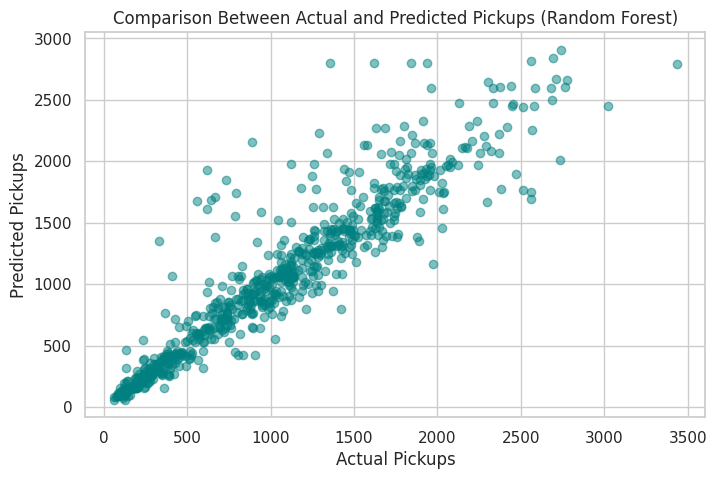

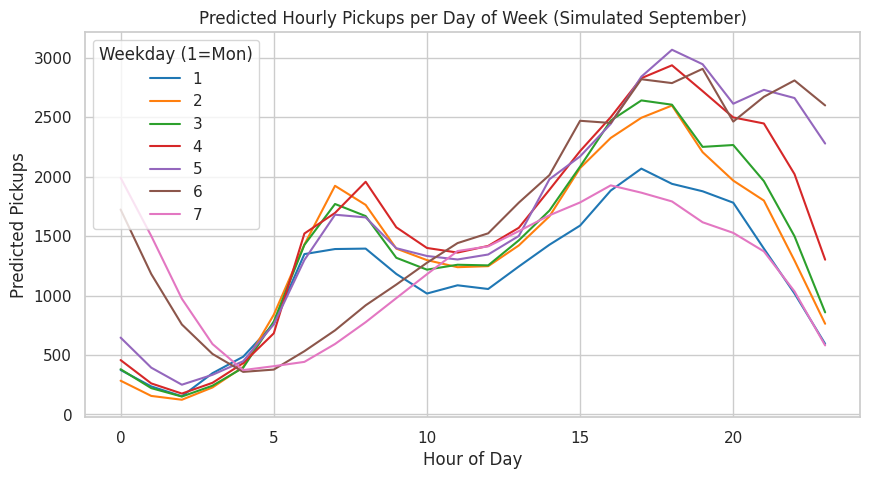


✅ Predictive analysis completed successfully!


In [ ]:
# ==========================================
# 🚖 Predictive Model on Uber Trips (May–September 2014)
# ==========================================

# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 📂 Load datasets from Google Drive
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

# 🔸 Paths to the CSV files (update if needed)
may = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-may14.csv")
jun = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jun14.csv")
jul = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-jul14.csv")
aug = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-aug14.csv")
sep = pd.read_csv("/content/drive/MyDrive/02 UniTrento Magistrale/1 anno/Data Mining/Project/Dataset/uber-raw-data-sep14.csv")

# 🔹 Merge all datasets into a single DataFrame
df = pd.concat([may, jun, jul, aug, sep])
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
print("✅ Combined dataset shape:", df.shape)
print(df.head())

# ==========================================
# 🕒 Feature Engineering
# ==========================================
# Extract useful time-related features from the datetime column
df['hour'] = df['Date/Time'].dt.hour
df['weekday'] = df['Date/Time'].dt.dayofweek + 1   # Monday = 1, Sunday = 7
df['month'] = df['Date/Time'].dt.month
df['date'] = df['Date/Time'].dt.date
df['date_hour'] = df['Date/Time'].dt.floor('h')    # Round down to the nearest hour

# ==========================================
# 📊 Aggregate data by hour (Target variable: number of pickups)
# ==========================================
pickup_by_time = df.groupby('date_hour').size().reset_index(name='pickups')

# Create time-based features for prediction
pickup_by_time['hour'] = pickup_by_time['date_hour'].dt.hour
pickup_by_time['weekday'] = pickup_by_time['date_hour'].dt.dayofweek + 1
pickup_by_time['month'] = pickup_by_time['date_hour'].dt.month

# ==========================================
# 🧠 Prepare data for the predictive model
# ==========================================
# Features: hour, weekday, month
# Target: number of pickups per hour
X = pickup_by_time[['hour', 'weekday', 'month']]
y = pickup_by_time['pickups']

# Split the data into training and test sets (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 🌲 Train the Random Forest Regression Model
# ==========================================
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ==========================================
# 📈 Evaluate model performance
# ==========================================
y_pred = model.predict(X_test)

# Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Mean Squared Error (MSE): {mse:.2f}")
print(f"📈 R² Score: {r2:.3f}")

# ==========================================
# 🔍 Visualize predicted vs actual pickups
# ==========================================
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.xlabel("Actual Pickups")
plt.ylabel("Predicted Pickups")
plt.title("Comparison Between Actual and Predicted Pickups (Random Forest)")
plt.show()

# ==========================================
# 🔮 Predict future hourly demand for a hypothetical week
# ==========================================
# Create a simulated week (7 days * 24 hours)
future = pd.DataFrame({
    'hour': list(range(0,24))*7,
    'weekday': np.repeat(np.arange(1,8), 24),  # Monday = 1, Sunday = 7
    'month': [9]*168  # Example: September
})

# Predict the number of pickups
future['predicted_pickups'] = model.predict(future[['hour', 'weekday', 'month']])

# Plot hourly predictions by day of the week
plt.figure(figsize=(10,5))
sns.lineplot(data=future, x='hour', y='predicted_pickups', hue='weekday', palette='tab10')
plt.title("Predicted Hourly Pickups per Day of Week (Simulated September)")
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Pickups")
plt.legend(title='Weekday (1=Mon)')
plt.show()

